![CC-BY-SA](https://mirrors.creativecommons.org/presskit/buttons/88x31/svg/by-sa.svg)


This notebook was created by [Bernardo Freitas Paulo da Costa](http://www.im.ufrj.br/bernardofpc),
and Pedro Angelo Medeiros Fonini
and is licensed under Creative Commons BY-SA.

Antes de enviar este Teste, verifique que tudo está funcionando como esperado.
Por exemplo, **rode o código inteiro, do zero**.
Para isso, vá no menu, escolha _Kernel_, depois _Restart & Run All_.

Verifique, também, que você respondeu todas as questões:
* as questões de código têm `YOUR CODE HERE` (e você pode apagar o `raise NotImplemented` ao incluir sua resposta)
* as questões discursivas têm "YOUR ANSWER HERE".

---

# Método da secante com extremidades de sinais opostos

O método da secante é extremamente eficiente para encontrar raízes de uma função,
devido à velocidade de convergência e simplicidade.
Entretanto, assim como no caso do método de Newton, não há garantias de que ele convirja.

Entretanto, adaptar a idéia do método da bisseção para a secante
não dá uma performance tão boa, já que a convergência é apenas linear:
na _Regula Falsi_, uma das extremidades permanece fixa a partir de um certo ponto do algoritmo.
Pior ainda, dependendo de onde esta extremidade estiver, a velocidade de convergência
pode ser menor do que a do método da bisseção!

O objetivo deste projeto é estudar algoritmos usando secantes:

1. O algoritmo original da secante,
2. A implementação da _Regula Falsi_, que mantém extremidades com sinais diferentes;
3. O método "de Illinois", uma variante mais eficiente.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## A bisseção

Como vamos trabalhar com métodos de intervalos,
é bastante natural incluir a bisseção junto à comparação.

A implementação abaixo, recursiva, usa variáveis auxiliares (`fa`, `fb`, por exemplo)
para evitar calcular $f(a)$ mais de uma vez ao longo do algoritmo.
Além disso, estas variáveis "a mais" serão úteis para a secante e o método de Illinois.

In [2]:
def bissecao(f,a,b,xtol=1e-8):
    """ Método da bisseção para a função  f  no intervalo  [a,b].

        Retorna um número  z,  que garantimos não estar mais longe da raiz do que  xtol,
        e as listas de extremidades esquerda e direita produzidas ao longo do algoritmo.
    """
    # Validando a entrada:
    fa = f(a)
    fb = f(b)
    assert(fa*fb < 0)
    
    # Estrutura recursiva básica
    def dividir(a,b,fa,fb):
        m = (a+b)/2
        # Garantia de erro absoluto 
        if abs(m-a)/2 < xtol:
            return m,[a],[b]
        fm = f(m)
        if fm == 0:
            return m,[a],[b]

        if fa*fm < 0:
            z,l,r = dividir(a,m,fa,fm)
        else:
            z,l,r = dividir(m,b,fm,fb)
        return z, [a]+l,[b]+r
    
    z,l,r = dividir(a,b,fa,fb)
    return z, np.array(l), np.array(r)

## Parte I: O método da secante

O método da secante parte de um intervalo $[a,b]$ para o intervalo $[b,s]$,
onde $s$ é a raiz da _secante_ ao gráfico de $f$ no intervalo $[a,b]$,
ou seja, o ponto $(s,0)$ é a interseção da reta determinada por $(a, f(a))$ e $(b, f(b))$.

### 1. Cálculo do passo

Determine $s$, em função de $a$, $b$, $f(a)$ e $f(b)$.

A reta que passa pelos pontos $(a, f(a))$ e $(b, f(b))$ tem forma analítica $y = \alpha x + \beta$ tal que:

$$\alpha = \frac{f(b) - f(a)}{b - a}$$

$$\beta = f(a) - \alpha a$$

Sendo $s$ a raiz dessa reta,

$$0 = \alpha s + \beta$$

$$\alpha s = - \beta$$

$$s = \frac{- \beta}{\alpha}$$

Verifique que a fórmula é **simétrica** em $a$ e $b$
(trocando também $f(a)$ por $f(b)$)

Outro jeito de se calcular $\alpha$ e $\beta$ são:

$$\alpha = \frac{f(a) - f(b)}{a - b}$$

$$\beta = f(b) - \alpha b$$

Que são as mesmas formas achadas anteriorimente mas trocando $a$ por $b$ e vice-versa.

### 2. Programação

Implemente o método da secante, modificando a função de bisseção acima.
Ao contrário da bisseção, o método da secante não precisa de sinais opostos,
e portanto dispensa alguns testes -
entretanto, também não garantimos a convergência,
então teremos que introduzir, como no método de Newton, critérios de parada
em termos do tamanho do passo e do número máximo de iteração,
sem _garantia_ de convergência.

Observe que, depois de passar do intervalo $[a,b]$ para $[b,s]$,
a "iteração seguinte" deve passar para $[s,t]$,
onde $t$ é a raiz da secante definida no intervalo $[b,s]$,
e assim por diante.
Desta forma, e para simplificar o código,
o "intervalo" $[a,b]$ (e todos os outros seguintes)
deve ser entendido de forma "não-orientada".
Assim, as extremidades "esquerda" e "direita" não correspondem sempre a $a$ e $b$, respectivamente!

In [3]:
def secante(f,a,b, xtol=1e-8, maxiter=100):
    """ Método da secante para a função  f  no intervalo  [a,b].

        Retorna um número  z  e as listas de extremidades esquerda e direita produzidas ao longo do algoritmo,
        que pára quando o último passo é menor do que  xtol, ou depois de  maxiter  iterações.
    """
    fa = f(a)
    fb = f(b)
    
    def passo(a, b, fa, fb):
        alpha = (fa - fb) / (a - b)
        beta = fa - alpha * a
        
        # 0 = alpha * s + beta
        # - beta / alpha = s
        return -beta / alpha
    
    # Estrutura recursiva básica
    def dividir(a,b,fa,fb, niters):
        
        s = passo(a, b, fa, fb)
        if (
            niters == maxiter or
            abs(a - b) < xtol or
            abs(b - s) < xtol
        ):
            return s, [a], [b]

        fs = f(s)
        if fs == 0:
            return s, [a], [b]

        z,l,r = dividir(b, s, fb, fs, niters + 1)
        return z, [a] + l, [b] + r
    
    z,l,r = dividir(a,b,fa,fb, 0)
    return z, np.array(l), np.array(r)

As caixas a segiur contém testes do seu método

In [4]:
z,_,_ = secante(np.sin,2,4)
assert( abs(z-np.pi) < 1e-8 )

In [5]:
# Esse teste é mais sério para a tolerância
def f(x):
    return 35*x**2 - x - 1
z,_,_ = secante(f,0,2,xtol=1e-12)
assert ( abs(z - (np.sqrt(141)+1)/70)  < 1e-12 )

In [6]:
# Esse teste é mais sério para $f(z) = 0$
z,l,r = secante(np.cos,0,2,xtol=1e-16)
assert (abs(z-np.pi/2) < 1e-16)

### 3. Um gráfico

A vantagem de retornar ambas extremidades do intervalo é que podemos fazer o gráfico do erro em função
do número de chamadas à função pedindo apenas uma tolerância suficientemente pequena.


Considere a função $f(x) = \sin(x)$ no intervalo $[0,1]$.
Faça o gráfico do tamanho do intervalo do método da secante em função do número de passos.
Note que o tamanho do intervalo é uma estimativa do erro do método independente do valor real da raiz.
Faça no mesmo eixo o gráfico do tamanho do intervalo da bisseção.

Pense bem nas escalas que você vai escolher.

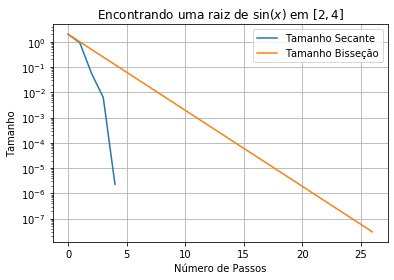

In [7]:
_, ls, rs = secante(np.sin,2,4)
passo_secante = np.array(range(len(ls)))
tamanho_secante = [
  np.abs(l - r) for l, r in zip(ls, rs)
]

_, lb, rb = bissecao(np.sin,2,4)
passo_bissecao = np.array(range(len(lb)))
tamanho_bissecao = [
  np.abs(l - r) for l, r in zip(lb, rb)
]

plt.semilogy(passo_secante,tamanho_secante,label ='Tamanho Secante')
plt.semilogy(passo_bissecao,tamanho_bissecao, label = 'Tamanho Bisseção')
plt.title('Encontrando uma raiz de $\sin(x)$ em $[2,4]$')
plt.xlabel('Número de Passos')
plt.ylabel('Tamanho')
plt.grid()
plt.legend();

### 4. Secante e Newton

Veja que o tamanho do intervalo tende bastante rápido a zero.
Uma explicação para isso é que a secante, quando intervalo fica pequeno, também é uma boa aproximação da derivada.
Que outras similaridades e diferenças há entre o método da secante e o método de Newton?

Uma primeira diferença é que o método da secante operada sobre um dado intervalo enquanto o método de Newton opera sobre uma estimativa da raíz.

Uma outra diferença é que o método da secante não precisa de derivadas então admite funções que não são $C^1$ no seu intervalo (e também não tem problemas com máximos ou mínimos locais no intervalo), enquanto o método de Newton precisa de funções diferenciáveis. 

Dito isso, existe uma semelhança na interpretação geométrica dos métodos. No fundo os dois métodos são baseados em desenhar uma reta (a secante ou a tangente) pra achar uma raíz.

## Parte II: A _Regula Falsi_

A _Regula Falsi_ parte de um intervalo $[a,b]$ onde a função $f$ tem sinais opostos
para o intervalo $[a,z]$ ou $[z,b]$, de modo a manter o sinal oposto,
o que garante que há uma raiz dentro do intervalo como no método da bisseção.
A diferença é que $z$ não é o ponto médio,
mas a interseção da reta determinada por $(a, f(a))$ e $(b, f(b))$,
como no caso do método da secante.

Para implementar a _Regula Falsi_, desejamos modificar o mínimo possível a função da bisseção acima.
Antes de escrever o código, vamos ver duas coisas.

### 5. Estimativa de erro da raiz

Dados um intervalo $[a,b]$ e o ponto $z$ obtido pelo método da secante,
determine o maior erro possível entre $z$ e uma raiz da função.

Explique como mudar o teste de saída da função que depende de `tol`.

No pior caso possível, teríamos a raíz em $a$ e a raíz da secante em $b$, logo podemos determinar que $|a - b|$ é um limite superior do erro.

Mesmo que essa situação seja extremamente improvável, essa fórmula nos dá uma maneira conservativa e convergente de calcular o erro.

### 6. Estimativas de $f(z)$.

- Suponha que $f(z) = 0$ e que o método _não testasse_ `f(z) == 0`. O que aconteceria na iteração seguinte?
- Diga porquê é **melhor** testar esta outra condição em vez de `f(z) == 0`. Dica: calcule `sin(pi)`.

Por razões de simetria, é mais razoável implementar o teste com `a` e `b`.

Suponha que temos um intervalo $[a,b]$ e que fazendo o método da secante, nós descobrimos $s$ tal que $f(s) == 0$.

Então o método vai dividir o intervalo em $[s,b]$, e na próxima iteração acharemos o intervalo $[s,s]$ e o método converge pelo tamanho do intervalo.

No método da Regula Falsi, assumamos sem perda de generalidade que o a raíz $s$ tem mesmo sinal que $a$, então na próxima iteração teríamos o intervalo $[s, b]$, necessariamente o algoritmo vai dar como raíz da secante, $s$.

Logo a próxima iteração também teria o intervalo $[s,b]$, logo se o intervalo se manteve entre duas iterações, podemos dizer que o algoritmo achou a raíz.

In [8]:
# Você pode usar esta caixa (e outras antes do item 3) para fazer testes se você quiser.

### 7. Implementando a _Regula Falsi_

Agora sim, adapte o código da bisseção para a _Regula Falsi_,
incluindo as modificações indicadas acima.

In [9]:
def regula_falsi(f,a,b,xtol=1e-8):
    """Método Regula false para uma uma função f no intervalo [a,b].
    
             Retorna um número  z  e as listas de extremidades esquerda e direita produzidas ao longo do algoritmo,
        que pára quando o último passo é menor do que  xtol """
    fa = f(a)
    fb = f(b)
    assert(fa*fb < 0)
    
    def dividir(a,b,fa,fb):
        s = (fa*b - a*fb)/(fa - fb)
        if a == s or b == s:
            return s,[a],[b]
        
        if abs(b-a) < xtol:
            return s,[a],[b]
        
        fs = f(s)
        if fa * fs < 0:
            z,l,r = dividir(a,s,fa,fs)
        else:
            z,l,r = dividir(s,b,fs,fb)
        return z, [a]+l,[b]+r
    
    z,l,r = dividir(a,b,fa,fb)
    return z, np.array(l), np.array(r)

In [10]:
# Teste aqui se a sua função está funcionando.
z,l,r = regula_falsi(np.sin,2,4)
z - np.pi

0.0

As quatro caixas a segiur contém testes do seu método

In [11]:
z,_,_ = regula_falsi(np.sin,2,4)
assert( abs(z-np.pi) < 1e-8 )

In [12]:
z,_,_ = regula_falsi(np.cos,0,4)
assert( abs(z-np.pi/2) < 1e-8 )

In [13]:
# Esse teste é mais sério para a tolerância
def f(x):
    return 35*x**2 - x - 1
z,_,_ = regula_falsi(f,0,2,xtol=1e-12)
assert ( abs(z - (np.sqrt(141)+1)/70)  < 1e-12 )

In [14]:
# Esse teste é mais sério para $f(z) = 0$
z,l,r = regula_falsi(np.cos,0,2,xtol=1e-16)
assert (abs(z-np.pi/2) < 1e-16)

### 8. Um gráfico

A vantagem de retornar ambas extremidades do intervalo é que podemos fazer o gráfico do erro em função
do número de chamadas à função pedindo apenas uma tolerância suficientemente pequena.


Considere a função $f(x) = \sin(x)$ no intervalo $[0,1]$.
Faça o gráfico do tamanho do intervalo da _regula falsi_ em função do número de passos.
Note que o tamanho do intervalo é uma estimativa do erro do método independente do valor real da raiz.
Faça no mesmo eixo o gráfico do tamanho do intervalo da bisseção.

Pense bem nas escalas que você vai escolher.

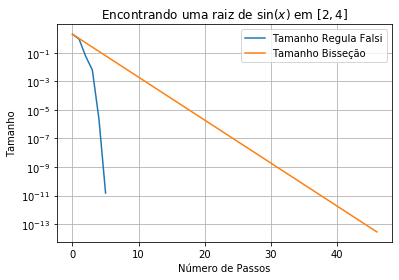

In [15]:
_, lrf, rrf = regula_falsi(np.sin,2,4,xtol=1e-14)
passo_regula_falsi = np.array(range(len(lrf)))
tamanho_regula_falsi = [
  np.abs(l - r) for l, r in zip(lrf, rrf)
]

_, lb, rb = bissecao(np.sin,2,4, xtol=1e-14)
passo_bissecao = np.array(range(len(lb)))
tamanho_bissecao = [
  np.abs(l - r) for l, r in zip(lb, rb)
]

plt.semilogy(passo_regula_falsi, tamanho_regula_falsi,label = 'Tamanho Regula Falsi')
plt.semilogy(passo_bissecao, tamanho_bissecao,label = 'Tamanho Bisseção')
plt.title('Encontrando uma raiz de $\sin(x)$ em $[2,4]$')
plt.xlabel('Número de Passos')
plt.ylabel('Tamanho')
plt.legend()
plt.grid();

### 9. Uma outra função

Agora, faça o gráfico para a função $g(x) = \sin(x) - 0.5$ também no intervalo $[0,1]$.
O que você vê de diferente?

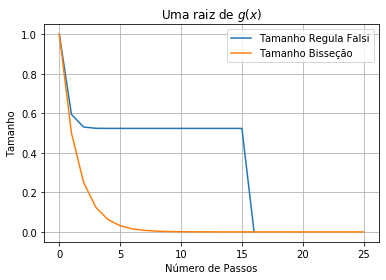

In [16]:
def g(x):
    return np.sin(x) - 0.5

_, lrf, rrf = regula_falsi(g,0,1)
_, lb, rb = bissecao(g,0,1)
tamanho_regula_falsi = [
  np.abs(l - r) for l, r in zip(lrf, rrf)
]

passo_regula_falsi = np.array(range(len(lrf)))

tamanho_bissecao = [
  np.abs(l - r) for l, r in zip(lb, rb)
]
passo_bissecao = np.array(range(len(lb)))

plt.plot(passo_regula_falsi,tamanho_regula_falsi,label = 'Tamanho Regula Falsi')
plt.plot(passo_bissecao,tamanho_bissecao,label = 'Tamanho Bisseção')
plt.title('Uma raiz de $g(x)$')
plt.xlabel('Número de Passos')
plt.ylabel('Tamanho')
plt.legend()
plt.grid();

No inicio o método da bisseção e da Regula Falsi tem convergências parecidas, mas a Regula Falsi tem um caso patológico que acaba causando convergência linear.

Quando a raíz da secante não troca de sinal por várias iterações, o tempo de convergência aumenta drasticamente.

In [17]:
for n in range(3, 15):
    print(f'a: {lrf[n]:}, b: {rrf[n]}')

a: 0.0, b: 0.5242632161127955
a: 0.0, b: 0.52366067961701
a: 0.0, b: 0.5236045392674236
a: 0.0, b: 0.5235993122010667
a: 0.0, b: 0.5235988255562161
a: 0.0, b: 0.523598780249397
a: 0.0, b: 0.5235987760313177
a: 0.0, b: 0.5235987756386131
a: 0.0, b: 0.5235987756020521
a: 0.0, b: 0.5235987755986483
a: 0.0, b: 0.5235987755983313
a: 0.0, b: 0.5235987755983019


## Parte III: O método "de Illinois"

Para evitar "_ficar preso_" de um lado da concavidade da função,
uma das idéias mais antigas (diz-se inventada pelo grupo da Universidade de Illinois no início dos anos 50)
é **dividir por dois** o valor de $f(a)$ (ou $f(b)$) quando a extremidade correspondente não mudar durante duas iterações consecutivas.
Assim, o algoritmo passa a ser:

- Calcule `(z,fz)` a partir de `(a,fa)` e `(b,fb)` como no método da secante,
- Substitua o par `(x,fx)` que tem o mesmo sinal de `fx` por `(z,fz)` como no método da bisseção,
- Se a extremidade restante - digamos `y` - já era uma extremidade na etapa anterior, substitua `(y,fy)` por `(y,fy/2)`.

### 10. Implemente esta modificação no código da `regula falsi`.
Embora exista uma solução com um truque, o mais simples é adicionar um argumento a `dividir`
para marcar qual ponto veio da iteração anterior.

In [18]:
def illinois(f,a,b,xtol=1e-8):
    """Método Regula false para uma uma função f no intervalo [a,b].
    
    Retorna um número  z  e as listas de extremidades esquerda e direita produzidas ao longo do algoritmo,
    que pára quando o último passo é menor do que  xtol """
    fa = f(a)
    fb = f(b)
    assert(fa*fb < 0)
    
    def dividir(a,b,fa,fb, a_velho, b_velho):
        s = (fa*b - a*fb)/(fa - fb)
        if a == s or b == s:
            return s, [a], [b]
        
        if abs(b-a) < xtol:
            return s,[a],[b]
        
        fs = f(s)
        if fa * fs < 0:
            if a == a_velho:
                fa /= 2
            
            z,l,r = dividir(a,s,fa,fs,a,b)
        else:
            if b == b_velho:
                fb /= 2
                
            z,l,r = dividir(s,b,fs,fb,a,b)
        return z, [a]+l,[b]+r
    
    z,l,r = dividir(a,b,fa,fb,a,b)
    return z, np.array(l), np.array(r)




A seguir, quatro testes análogos ao da _regula falsi_, mas agora para o método de Illinois.

In [19]:
z,_,_ = illinois(np.sin,2,4)
assert( abs(z-np.pi) < 1e-8 )

In [20]:
z,_,_ = illinois(np.cos,0,4)
assert( abs(z-np.pi/2) < 1e-8 )

In [21]:
# Esse teste é mais sério para a tolerância
def f(x):
    return 35*x**2 - x - 1
z,_,_ = illinois(f,0,2,xtol=1e-12)
assert ( abs(z - (np.sqrt(141)+1)/70)  < 1e-12 )

In [22]:
# Esse teste é mais sério para $f(z) = 0$
z,l,r = illinois(np.cos,0,2,xtol=1e-16)
assert (abs(z-np.pi/2) < 1e-16)

### 11. Mais um gráfico

Aproveite a função $g$ acima para ver que o método de Illinois não tem o mesmo problema que a _regula falsi_:
faça em um mesmo eixo os gráficos do tamanho do intervalo para ambos os métodos. (Não precisa da bisseção)

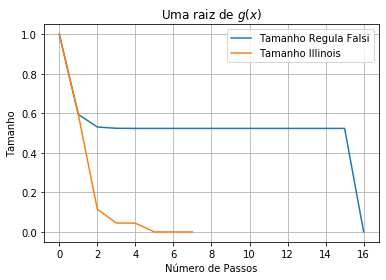

In [23]:
def g(x): return np.sin(x) - .5

_, lrf, rrf = regula_falsi(g,0,1)
_, lb, rb = illinois(g,0,1)
tamanho_regula_falsi = [
  np.abs(l - r) for l, r in zip(lrf, rrf)
]

passo_regula_falsi = np.array(range(len(lrf)))

tamanho_illinois = [
  np.abs(l - r) for l, r in zip(lb, rb)
]
passo_illinois = np.array(range(len(lb)))

plt.plot(passo_regula_falsi,tamanho_regula_falsi,label = 'Tamanho Regula Falsi')
plt.plot(passo_illinois,tamanho_illinois,label = 'Tamanho Illinois')
plt.title('Uma raiz de $g(x)$')
plt.xlabel('Número de Passos')
plt.ylabel('Tamanho')
plt.legend()
plt.grid();

## Parte IV: Análise do método de Illinois

Esta parte final faz a análise numérica do método de Illinois,
para demonstrar a sua eficiência.

### 12. Entendendo as iterações do método de Illinois

Suponha que $f(x) = Cx^2 + Dx$ com ambos $C$ e $D$ positivos.
Suponha também que o método de Illinois está no intervalo $[a,b]$, com $a < 0 < b$ e $f(a) < 0 < f(b)$.

- Mostre que $z < 0$.
- Mostre que isso implica que somente a extremidade superior pode ficar parada.

Observação: Se quiser, escreva $a = -x$ para acertar os sinais.

1. Para provar que $z < 0$, vamos usar a fórmula do passo:
\begin{align*}
z = \frac{f(b)a - f(a)b}{f(b) - f(a)}
\end{align*}

Analisando, vemos que $f(b) - f(a)$ com certeza é positivo, então basta analisar o sinal do numerador.
Então, queremos provar que:

\begin{align*}
f(b)a - f(a)b \stackrel{?}{<} 0\\
(Cb^2 + Db)a - (Ca^2 +Da)b \stackrel{?}{<} 0\\
Cb^2a - Ca^2b \stackrel{?}{<} 0\\
Cab(b - a) \stackrel{?}{<} 0
\end{align*}

Como $a < 0 < b$ e $C>0$, o produto $Cab$ é negativo e portanto podemos concluir que z é com certeza negativo.

\begin{align*}
Cab(b - a) < 0
\end{align*}

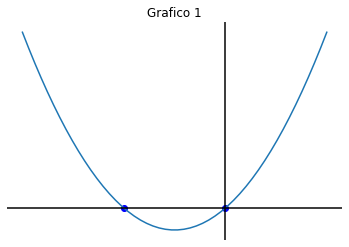

In [24]:
def p(x):
    return x**2 + x

x = np.linspace(-2, 1)
y = np.empty(len(x))

for i,j in enumerate(x):
    y[i] = p(j)

plt.plot(x,y)
plt.axhline(color = 'black')
plt.axvline(color = 'black')
plt.axis('off')
plt.grid()
plt.title('Grafico 1')
plt.scatter([-1, 0], [0,0], marker='o', color='b');

2. Como $z$ é negativo e está dentro intervalo $[a,0[$, o produto $f(z)f(b)$ também será negativo, logo a extremidade b fica parada

### 13. O passo modificado de Illinois

Vamos mostrar que o "passo modificado" implica em alterar a extremidade superior do intervalo.
Para simplificar um pouco as contas,
daqui em diante, suponha que $C = D = 1$, e $-1/3 < a < 0 < b < 1/3$.

Mostre os três fatos a seguir:

1. Nessas condições, $\lvert z\rvert < \lvert ab \rvert$. e $|a| < |b|$ 

2. O ponto $(b, f(b)/2)$ está abaixo da reta tangente a $f$ no ponto $(z, f(z))$. (Não substitua o valor de $z$: basta usar a estimativa acima e que $0 < b < 1/3$)

3. Enfim, conclua que a interseção da reta ligando $(z, f(z))$ e $(b, f(b)/2)$ com o eixo $X$ é positiva.

 1. $ \large \left | \frac {ab(b -a)}{(b - a)(b + a + 1)}  \right | = |ab| \cdot \frac{1}{b + a + 1} $ ,mas $\large 0 < \frac{1}{b + a + 1} < 1$ então $ \large  |ab| \cdot \frac{1}{b + a + 1} = |z| < |ab| < b^2 < b    $ 
2. Seja $r$ a reta tangente a curva no ponto $(z,f(z))$, entao $r: y = (2z+1)x - z^2$. Quero mostrar que $y - f(b)/2 > 0$ .
\begin{align*}
y = (2z+1)b - z^2 \text{ , para }  z >= -b^2:\\
y = (-2b^2+1)b - b^4\\
(1-2b^2) - b^4 ?> (b^2+b)/2\\
2(1-b^2) - 2b^4 > b^2 + b\\
2 - 4b^2 - 2b^3 > b + 1
\end{align*}
Veja no gráfico abaixo que para todos os valores de b no intervalo $[0,1/3]$ é valido a desigualdade, o que garante que o ponto $(b,f(b)/2)$ está abaixo da reta tangente a f no ponto $(z,f(z))$ 


3. $ \frac {f(z) - f(b)/2}{z - b}(x - z) = y - f(z)$ , quero o ponto (s,0) => $ \large \frac {f(z) - f(b)/2}{z - b}(s - z) = 0 - f(z) => s = \frac{-f(z)\cdot (z-b)}{f(z) - f(b)/2} +z  =  \frac{f(z)b - f(b)\frac{z}{2}}{f(z) - f(b)/2} $ se z = -b ("menor valor") =>  $\large \frac{f(-b)b - f(b)\frac{-b}{2}}{f(-b) - f(b)/2} = \frac {b^2(3b - 1)}{2f(-b) - f(b)} > 0  $,  então s é positivo para todos os valores.


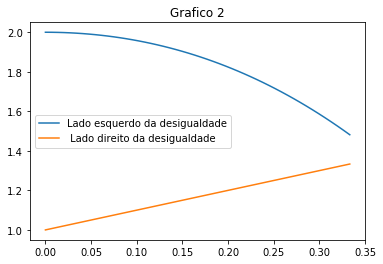

In [25]:
def f(x): return 2 - 4*x**2 - 2*x**3 
def g(x): return x + 1 
fs = []
gs = []
eixo_x = np.linspace(0,1/3)
for x in np.linspace(0, 1/3):
  fs += [f(x)]
  gs += [g(x)]
plt.plot(eixo_x,fs,label = 'Lado esquerdo da desigualdade')
plt.plot(eixo_x,gs,label = ' Lado direito da desigualdade')
plt.title('Grafico 2')
plt.legend();

### 14. O "período" do método de Illinois

Com isso, é possível concluir que o método de Illinois, quando suficientemente perto das raízes,
tem o seguinte comportamento:

1. Uma iteração produz um $z < 0$ de módulo menor do que $b$;
2. A iteração seguinte produz outro $z < 0$, e portanto também abaixa o valor de `fb`;
3. A terceira iteração produz um valor $z > 0$, e daí em diante esse ciclo se repete.

1. $ \large \left | \frac {ab(b -a)}{(b - a)(b + a + 1)}  \right | = |ab| \cdot \frac{1}{b + a + 1} $ ,mas $\large 0 < \frac{1}{b + a + 1} < 1$ então $ \large  |ab| \cdot \frac{1}{b + a + 1} = |z| < |ab| $ mas $\large |a|<1/3 \rightarrow |ab| < b/3 < b \rightarrow |z| < b$
2. $\large [z,b], z' = \frac {zf(b) - bf(z)}{f(b) - f(z)} < 0 $, pois $\large f(b) - f(z)$ é positivo e $\large zf(b) <0$ e $\large bf(z) < 0$, veja que a função no intervalo dado é estritamente crescente como mostra o grafico e para todo x pertencente ao intervalo $]-1/3,0[    \large \rightarrow f(x) < 0$. Então $\large f(z') \cdot f(b) < 0 \rightarrow [z'b] $. Como b se manteve inalterado por duas iterações, então no próximo passo trocaremos o ponto $\large (b,f(b))$ por $\large (b,f(b)/2)$
3. $\large [z',b], z" = \frac {z'f(b)/2 - bf(z')}{f(b)/2 - f(z')} > 0$ (Veja que é verdade de acordo com o passo $13.3$).$f(z")> 0$ pois para todos os valores positivos de $x$, $f(x)$ também é positivo (veja no grafico 1) , então  $ f(z") \cdot f(z') < 0 \rightarrow$ trocamos o intervalo para $[z',z"] $. Como o intervalo gerado continua respeitando as propriedades inciais como $-1/3 < z' < 0 < z" < 1/3$, pois $z" < b$ e $z'> a$, garantimos que o ciclo se repete.  

### 15. Primeira estimativa de velocidade

Agora, se $b$ e $a$ são pequenos, mostre que $z \sim ab$.
Este comportamento "quadrático" é o que torna o método da secante rápido.

Pra valores suficientemente pequenos de $a$ temos que pra qualquer $n$ real positivo e $k$ real, $k \cdot a^n \sim a$, logo pra qualquer $f$ que é polinomial (ou $C^n$ e portanto expresso como uma série polinomial), $f(a) \sim a$

Uma conclusão análoga pode ser obtida para $b$.

Portanto, usando a fórmula do passo, temos que:
$$z = \frac{f(b)a - f(a)b}{f(b) - f(a)}$$

$$z \sim \frac{f(b)ba - f(a)ba}{f(b) - f(a)}$$

$$z \sim \frac{(f(b) - f(a))ba}{f(b) - f(a)}$$

$$z \sim ab$$

Também é possível mostrar que, após efetuarmos um "passo modificado",
a iteração seguinte gera uma nova extremidade superior de módulo aproximadamente igual ao da extremidade inferior.
Assim, temos que em três passos saímos do intervalo $[a,b]$ para aproximadamente $[-a^2 b, a^2b]$.

Portanto, se começarmos de um intervalo $[-x,x]$, em três passos estaremos aproximadamente no intervalo $[-x^3,x^3]$.

### 16. Estimando a velocidade de convergência

- Suponha que no $n$-ésimo passo estamos no intervalo $[-x_n, x_n]$. Tome logaritmos, e deduza uma relação de recorrência aproximada entre $x_n$ e $x_{n+3}$.
- Se começamos em $[-x_0, x_0]$, qual é o tamanho (aproximado) do intervalo que atingimos em $3n$ passos?
- Conclua que o método de Illinois é super-linear.

### Primeiro ponto:
##### Passo 1:
$x_{n+1} \approx -x_n^2$ para $x_n$ pequeno.
Considerando que $x_n > 0$, então $x_{n+1} \cdot x_n < 0$ e nosso intervalo será $[-x_n^2,x_n]$.
##### Passo 2:
$x_{n+2} \approx -x_n^3 $, então $x_{n+2}\cdot x_n < 0$ e o novo intervalo será $[-x_n^3,x_n]$.
##### Passo 3: 
Como o lado direito se repetiu em duas iterações consecutivas, teremos que considerar o ponto $(x_n,f(x_n)/2)$, então:
$$x_{n+3} = \frac{-f(x_n)x_n^3 - 2f(-x_n^3)x_n}{f(x_n) - 2f(-x_n^3)}$$
$$x_{n+3} = \frac{-(x_n^2 + x_n)x_n^3 - 2(x_n^6 - x_n^3)x_n}{(x_n^2 + x_n) - 2(x_n^6 - x_n^3)}$$

Mas $x_n$ é muito pequeno, então:
$$x_{n+3} = \frac{-(x_n^2 + x_n)x_n^3 - 2(x_n^6 - x_n^3)x_n}{(x_n^2 + x_n) - 2(x_n^6 - x_n^3)}= \frac{-2x_n^6 -x_n^5 + x_n^4}{-2x_n^6 - 2x_n^3 + x_n^2 + x_n} \approx \frac{x_n^4}{x_n} = x_n^3$$

As contas são analogas se considerarmos $x_n < 0$. Portanto $x_n^3 \cdot -x_n^3 < 0$ => $[-x_n^3,x_n^3] = [-x_{n+3},x_{n+3}]$
### Segundo ponto:
Queremos provar que $x_{n+3} = x_{n}^3 $
#### Indução:
1. n = 0: $x_3 = x_0^3$
Verdade! Resultado da questão 15 fazendo $x = x_0$ .

2. Suponha que vale para algum n natural > 0 , tal que $x_{n+3} = x_{n}^{3}$

3. Provar para $n+3$:

###### Passo 1:
$x_{n+4} \approx -x_{n+3}^2$ para $x_{n+3}$ pequeno.
Considerando que $x_{n+3} > 0$, então $x_{n+3} \cdot x_{n+4} < 0$ e nosso intervalo será $[-x_{n+3}^2,x_{n+3}]$.

###### Passo 2:
$x_{n+5} \approx -x_{n+3}^3 $, então $x_{n+5}\cdot x_{n+4} < 0$ e o novo intervalo será $[-x_{n+3}^3,x_{n+3}]$.

###### Passo 3: 
Como o lado direito se repetiu em duas iterações consecutivas, teremos que considerar o ponto $(x_{n+3},f(x_{n+3})/2)$, então:
$$x_{n+6} = \frac{-f(x_{n+3})x_{n+3}^3 - 2f(-x_{n+3}^3)x_{n+3}}{f(x_{n+3}) - 2f(-x_{n+3}^3)}$$
$$x_{n+6} = \frac{-(x_{n+3}^2 + x_{n+3})x_{n+3}^3 - 2(x_{n+3}^6 - x_{n+3}^3)x_{n+3}}{(x_{n+3}^2 + x_{n+3}) - 2(x_{n+3}^6 - x_{n+3}^3)}$$

Mas $x_{n+3}$ é muito pequeno, então:
$$x_{n+6} = \frac{-(x_{n+3}^2 + x_{n+3})x_{n+3}^3 - 2(x_{n+3}^6 - x_{n+3}^3)x_{n+3}}{(x_{n+3}^2 + x_{n+3}) - 2(x_{n+3}^6 - x_{n+3}^3)} =  \frac{-2x_{n+3}^6 - x_{n+3}^5 + x_{n+3}^4}{-2x_{n+3}^6 - 2x_{n+3}^3 + x_{n+3}^2 + x_{n+3}} \approx \frac{x_{n+3}^4}{x_{n+3}} = x_{n+3}^3$$
C.Q.D
4. Demostrado o resultado, então $x_3 \approx x_0^3, x_6 \approx x_3^3, ... , x_{3n} \approx x_{3(n-1)}$ => $x_n \approx x_0^{3^n}$. Logo, o intervalo é aproximadamente $|2x_0^{3^n}|$
### Terceiro ponto:
$\large \lim_{n\rightarrow \infty} \frac{x_n}{x_{n+3}}$ = $\large \lim_{n\rightarrow \infty} \frac{x_0^{3^{n}}}{x_0^{3^{n+3}}}$ =  $\large \lim_{n\rightarrow \infty} \frac{1}{x_0^{3^{(n+3)} - 3^{n}}}$ = 0 , logo isso mostra que o método de Illinois é super linear. 